In [451]:
# 모듈 로딩

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from torchmetrics.classification import F1Score
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[1] 데이터 로딩 <hr>

In [452]:
DATA_FILE = '../../Data/iris.csv'

In [453]:
torch.manual_seed(1)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [454]:
irisDF = pd.read_csv(DATA_FILE)
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


[2] 데이터 전처리 <hr>

In [455]:
# 결측치 체크

print(irisDF.isnull().sum())

sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64


In [456]:
# 피쳐, 타겟 나누기

featureDF, targetDF = irisDF[irisDF.columns[:-1]], irisDF[irisDF.columns[[-1]]]
print(featureDF.shape, targetDF.shape)

print(featureDF.head())
print('----------------------------------------------------')
print(targetDF.head())

(150, 4) (150, 1)
   sepal.length  sepal.width  petal.length  petal.width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
----------------------------------------------------
  variety
0  Setosa
1  Setosa
2  Setosa
3  Setosa
4  Setosa


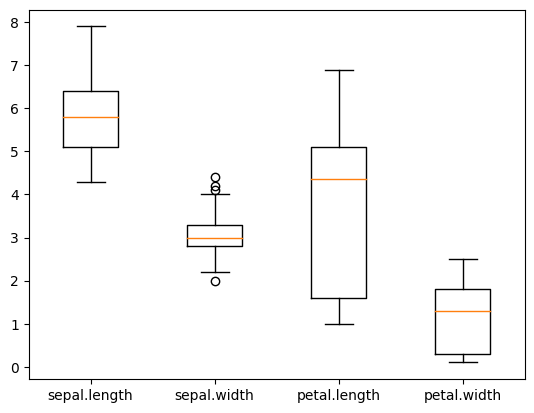

In [457]:
# 이상치 체크

plt.figure()
plt.boxplot(featureDF)
plt.xticks(range(1, 5), featureDF.columns)
plt.show()

[3] 데이터셋 인스턴스 생성 <hr>

In [458]:
# ------------------------------------------------
# 클래스 목적 : 학습용 데이터셋 텐서화 및 전처리
# 클래스 이름 : CustomDataSet
# 부모 클래스 : torch.utils.data.Dataset
# 매개 변수   : featureDF, targetDF 
# ------------------------------------------------

class CustomDataset(Dataset):
    # 데이터 로딩 및 전처리 진행과 인스턴스 생성 메서드
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]

    
    # 데이터의 개수 반환 메서드
    def __len__(self):
        return self.n_rows

    
    # 특정 index의 데이터와 타겟 반환 메서드 => Tensor 반환!!   
    def __getitem__(self, idx):
        featureTS = torch.FloatTensor(self.featureDF.iloc[idx].values).to(DEVICE)
        targetTS = torch.FloatTensor(self.targetDF.iloc[idx].values).to(DEVICE)
        return featureTS, targetTS

In [459]:
# ----------------------------------------------
# 함수 기능 : 파일 확장자별 데이터 프레임 변환 기능
# 함수 이름 : convertDataFrame
# 매개 변수 : file_path 파일 경로
# 함수 결과 : DataFrame
# ----------------------------------------------

def convertDataFrame(file_path, exit_header = 0):
    ext = file_path.rsplit('.')[-1]
    if ext == 'csv':
        return pd.read_csv(file_path, header = exit_header)
    
    elif ext == 'json':
        return pd.read_json(file_path, header = exit_header)
    
    elif ext in ['xlsx', 'xls']:
        return pd.read_excel(file_path, header = exit_header)
    
    else:
        return pd.read_table(file_path, header = exit_header)

In [460]:
# -----------------------------------------
# 클래스 기능 : 파일 기반 데이터셋
# 클래스 이름 : FileDataset
# 매개 변수 : file_path 파일 경로
# 부모 클래스 : utils.data.Dataset
# -----------------------------------------

class FileDataset(Dataset):
    def __init__(self, file_path):
        super().__init__()

        dataDF = convertDataFrame(file_path)
        self.featureDF = dataDF[dataDF.columns[:-1]]
        
        encoding = LabelEncoder()
        encoding.fit(dataDF['variety'])
        dataDF['variety'] = encoding.transform(dataDF['variety'])

        self.targetDF = dataDF[dataDF.columns[[-1]]]

        self.n_features = self.featureDF.shape[1]
        self.n_rows = self.featureDF.shape[0]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, idx):
        featureTS = self.featureDF.iloc[idx]
        targetTS = self.targetDF.iloc[idx]

        return featureTS, targetTS

In [461]:
irisDS = FileDataset(DATA_FILE)
irisDS

In [462]:
irisDS.n_features, irisDS.n_rows

(4, 150)

In [463]:
irisDS[:][1]

,variety
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


[4] 데이터 로더 인스턴스 생성 <hr>

In [464]:
X_train, X_test, y_train, y_test = train_test_split(irisDS[:][0],
                                                    irisDS[:][1],
                                                    test_size = 0.2,
                                                    random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.2,
                                                  random_state = 1)

print(X_train.shape, X_val.shape, X_test.shape)

train_dataset = CustomDataset(X_train, y_train)

print(train_dataset.__len__())
print(train_dataset)
print(X_val)

(96, 4) (24, 4) (30, 4)
96
     sepal.length  sepal.width  petal.length  petal.width
81            5.5          2.4           3.7          1.0
38            4.4          3.0           1.3          0.2
23            5.1          3.3           1.7          0.5
72            6.3          2.5           4.9          1.5
43            5.0          3.5           1.6          0.6
116           6.5          3.0           5.5          1.8
113           5.7          2.5           5.0          2.0
143           6.8          3.2           5.9          2.3
100           6.3          3.3           6.0          2.5
1             4.9          3.0           1.4          0.2
0             5.1          3.5           1.4          0.2
57            4.9          2.4           3.3          1.0
69            5.6          2.5           3.9          1.1
13            4.3          3.0           1.1          0.1
129           7.2          3.0           5.8          1.6
111           6.4          2.7           5.3 

In [465]:
trainDL = DataLoader(train_dataset, batch_size = 6)
len(trainDL)

16

In [466]:
for dataTS, targetTS in trainDL:
    print(dataTS.shape, targetTS.shape)
    print(dataTS.shape[1])

torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4
torch.Size([6, 4]) torch.Size([6, 1])
4


[5] 모델 준비 <hr>

In [467]:
# --------------------------------------------------------------
# 모델 이름 : CustomModel
# 부모 클래스 : nn.Module
# 매개 변수 : None
# 모델 구조
# - 입력층 : 입력 4개     출력 10개    AF ReLU -> LeakyReLU
# - 은닉층 : 입력 10개    출력 30개    AF ReLU -> LeakyReLU
# - 출력층 : 입력 30개    출력 3개     AF 분류 - 다중 softmax
# --------------------------------------------------------------

class CustomModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(4, 10)
        self.hidden_layer = nn.Linear(10, 30)
        self.out_layer = nn.Linear(30, 3)

    def forward(self, x):
        y = F.relu(self.in_layer(x))
        y = F.relu(self.hidden_layer(y))

        return self.out_layer(y)

In [468]:
model = CustomModel()
print(model)
summary(model, input_size = (100000, 4))

CustomModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=30, bias=True)
  (out_layer): Linear(in_features=30, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [100000, 3]               --
├─Linear: 1-1                            [100000, 10]              50
├─Linear: 1-2                            [100000, 30]              330
├─Linear: 1-3                            [100000, 3]               93
Total params: 473
Trainable params: 473
Non-trainable params: 0
Total mult-adds (M): 47.30
Input size (MB): 1.60
Forward/backward pass size (MB): 34.40
Params size (MB): 0.00
Estimated Total Size (MB): 36.00

[6] 학습 <hr>

In [469]:
adam_optim = optimizer.Adam(model.parameters(), lr = 0.01)

In [470]:
def testing(testDF, targetDF, kind):
    testTS = torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)

    with torch.no_grad():
        pre_y = model(testTS)
        targetTS = targetTS.reshape(-1).long()
        loss = nn.CrossEntropyLoss()(pre_y, targetTS)
        
        f1 = F1Score(task = 'multiclass', num_classes = 3, average = 'micro')(pre_y, targetTS)

        print(f"[{kind}] LOSS : {loss}, F1 : {f1}")
    
    return loss, f1

In [471]:
def training(valTS, valTargetTS):

    TS_loss, TS_score = [[], []], [[], []]

    for epoch in range(100):
        loss_total, score_total = 0, 0
        
        for dataTS, targetTS in trainDL:
            print(dataTS.shape, targetTS.shape)

            pre_y = model(dataTS)
            targetTS = targetTS.reshape(-1).long()
            print(pre_y.shape, targetTS.shape)

            loss = nn.CrossEntropyLoss()(pre_y, targetTS)
            loss_total += loss.item()
            score_total += F1Score(task = 'multiclass', num_classes = 3, average = 'micro')(pre_y, targetTS).item()

            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()
        
        val_loss, val_f1 = testing(valTS, valTargetTS, 'Val')
        TS_loss[1].append(val_loss)
        TS_score[1].append(val_f1)

        TS_loss[0].append(loss_total / len(trainDL))
        TS_score[0].append(score_total / len(trainDL))

        print(f"[{epoch + 1}/{100}]\n - TRAIN LOSS : {TS_loss[0][-1]} F1 : {TS_score[0][-1]}")
        print(f"- TRAIN LOSS : {TS_loss[1][-1]} F1 : {TS_score[1][-1]}")

    return TS_loss, TS_score
    

In [472]:
loss, f1 = training(X_val, y_val)


torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6

torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6, 3]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6, 1])
torch.Size([6

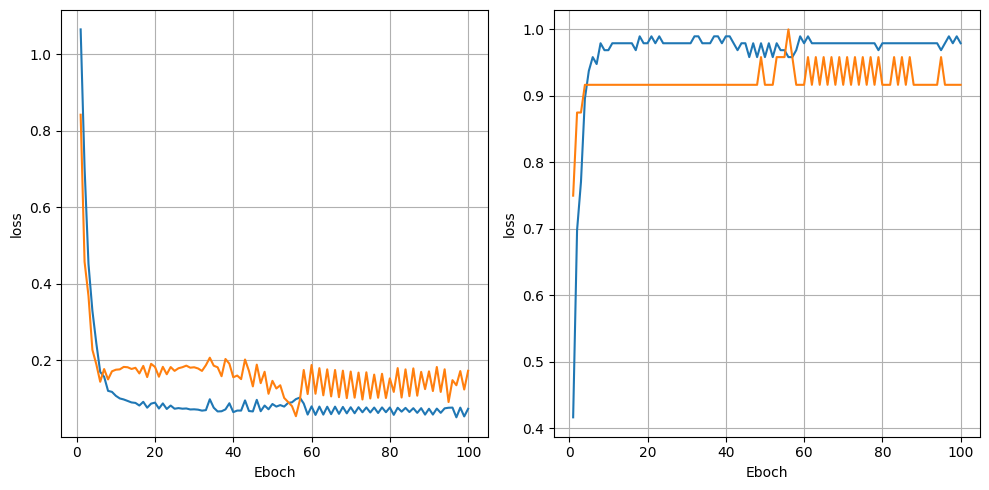

In [473]:
THRESHOLD = 100
fg, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, THRESHOLD + 1), loss[0], label = 'Train')
axes[0].plot(range(1, THRESHOLD + 1), loss[1], label = 'Val')
axes[0].grid()
axes[0].set_xlabel('Eboch')
axes[0].set_ylabel('loss')

axes[1].plot(range(1, THRESHOLD + 1), f1[0], label = 'Train')
axes[1].plot(range(1, THRESHOLD + 1), f1[1], label = 'Val')
axes[1].grid()
axes[1].set_xlabel('Eboch')
axes[1].set_ylabel('loss')

plt.tight_layout()
plt.show()